# Airport recommendation

In [102]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

import xgboost as xgb

RANDOM_SEED = 42

### Data exploration

In [103]:
#   Loading the data tables

data_dir = "./data"

airports_table = pd.read_csv(os.path.join(data_dir, "airports.csv"))

#   Each line is in quotation marks...
airports_tol_table= pd.read_csv(os.path.join(data_dir, "airports_terms_of_lease.csv"))
airports_tol_table = airports_tol_table["Airport,sqm of store,price per sqm/month"].str.split(',', expand=True)
airports_tol_table.columns = "Airport,sqm of store,price per sqm/month".split(",")

passengers_eu_table = pd.read_csv(os.path.join(data_dir, "passengersEU.csv"))

passengers_ww_table = pd.read_csv(os.path.join(data_dir, "passengersWW.csv"))



In [104]:
#   Inspect airports table

print("--- airports table (all; EU and WW) ---")

display("Sample: ", airports_table.head())

display('Statistics: ', 
        airports_table.describe(include='all'))


--- airports table (all; EU and WW) ---


'Sample: '

,name,continent,iso_country,iata_code,coordinates
0,Brussels Airport,EU,BE,BRU,"50.901401519800004,4.48443984985"
1,Frankfurt am Main Airport,EU,DE,FRA,"50.033333,8.570556"
2,DÃ¼sseldorf Airport,EU,DE,DUS,"51.289501,6.76678"
3,Munich Airport,EU,DE,MUC,"48.353802,11.7861"
4,Stuttgart Airport,EU,DE,STR,"48.689899444599995,9.22196006775"


'Statistics: '

,name,continent,iso_country,iata_code,coordinates
count,34,34,34,34,34
unique,34,5,24,34,34
top,Brussels Airport,EU,DE,BRU,"50.901401519800004,4.48443984985"
freq,1,22,5,1,1


In [105]:
#   Inspect airports tol table

print("--- airports terms of lease table (for proposed airports) ---")

display("Sample: ", airports_tol_table.head())

display('Statistics: ', 
        airports_tol_table.describe(include='all'))

--- airports terms of lease table (for proposed airports) ---


'Sample: '

,Airport,sqm of store,price per sqm/month
0,DFW,42,21
1,DXB,151,23
2,EZE,276,23
3,HKG,150,28
4,HND,117,23


'Statistics: '

,Airport,sqm of store,price per sqm/month
count,12,12,12
unique,12,12,6
top,DFW,42,23
freq,1,1,3


--- EU passengers table (at existing stores in EU) ---


'Sample: '

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Christian Kluge,m,1977/02/28,BCN,yes,no,Sports Bag 19l,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN
1,Bernd Jung,m,05/10/1971,MUC,no,no,Bag 19kg,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK
2,Ralph Dewhirst,m,10/04/1984,HEL,no,no,Duffel Bag [31KG],371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN
3,Jan Egger,m,1973/01/21,VIE,no,no,Bag 16kg,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN
4,Tom Probst,m,31/03/1985,FRA,yes,no,Bag (5KG),1197.70,1655.78,458.08,3,CA 6749,ZNZ,NaN,DL 7477,NaN,MEX


'Statistics: '

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
count,132234,132234,132234,132234,132234,132234,132234,132234.000000,132234.000000,132234.000000,132234.000000,132234,125922,124178,39966,31910,39966
unique,116550,2,37999,22,2,2,2715,NaN,NaN,NaN,NaN,37061,192,192,10505,22,192
top,Martina Klug,m,08/10/1979,ATH,no,no,Bag 4lbs,NaN,NaN,NaN,NaN,WN 2087,ATH,PMI,MS 4819,ATH,MEL
freq,7,66296,17,6383,85117,106646,206,NaN,NaN,NaN,NaN,11,3128,3365,27,1594,571
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,522.888465,611.546520,88.658055,1.652079,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,304.346226,417.880876,160.343163,1.379051,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.550000,52.550000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.330000,220.330000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,557.105000,580.100000,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.730000,874.970000,132.220000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN


Distributions: 


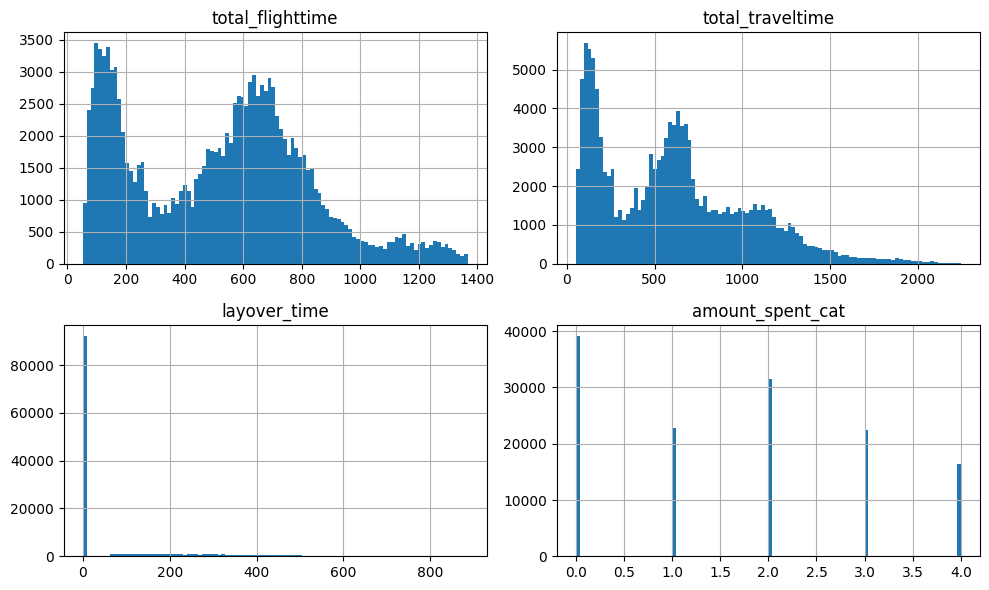

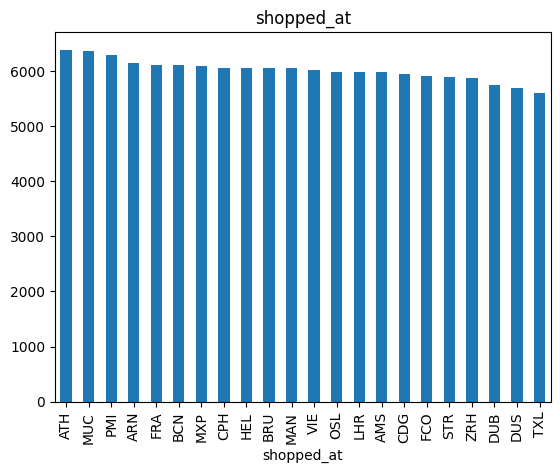

In [106]:
#   Inspect EU passengers table

print("--- EU passengers table (at existing stores in EU) ---")

display("Sample: ", passengers_eu_table.head())

display('Statistics: ', 
        passengers_eu_table.describe(include='all'))

print("Distributions: ")
passengers_eu_table.hist(bins=100, figsize=(10, 6), grid=True)
plt.tight_layout()
plt.show()

passengers_eu_table["shopped_at"].value_counts().plot(kind='bar', title="shopped_at")
plt.show()

    

--- WW passengers table (at proposed airports) ---


'Sample: '

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Gabriela Schmidlin,f,24/06/1984,HND,yes,no,Brief Case (4L),744.43,744.43,0.0,6U 2572,HND,ADD,NaN,NaN,NaN
1,Kaixin Banacloche,f,31/05/1992,KUL,yes,no,Duffel Bag 12KG,732.68,732.68,0.0,AF 1390,KUL,AMS,NaN,NaN,NaN
2,Manuela Thalberg,f,11/05/1964,HND,yes,no,Duffel Bag 7lbs,523.70,523.70,0.0,SQ 1981,BNE,HND,NaN,NaN,NaN
3,Klaudia Osterhagen,f,17/09/1994,SFO,no,yes,Duffel Bag 16L,876.85,876.85,0.0,IBE 4556,DEL,SFO,NaN,NaN,NaN
4,Cris Caci,f,20/06/1990,JFK,yes,no,Cosmetic Case (3lbs),1077.70,1634.20,556.5,EK 0016,CPT,JFK,QR 8307,JFK,HAV


'Statistics: '

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
count,73140,73140,73140,73140,73140,73140,73140,73140.000000,73140.000000,73140.000000,73140,73140,73140,20900,20900,20900
unique,62970,2,18255,12,2,2,2715,NaN,NaN,NaN,19066,192,192,4238,12,192
top,Leon Diederich,f,04/06/1975,HND,no,no,Messenger Bag 5kg,NaN,NaN,NaN,ET 3904,KUL,HND,JL 4312,HND,MEL
freq,7,36734,17,7689,46829,59212,127,NaN,NaN,NaN,18,3477,4789,40,3173,439
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798.236909,908.836424,110.599515,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298.915770,444.879724,206.704438,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.170000,51.170000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,602.870000,605.920000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,797.870000,834.530000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1031.250000,1154.030000,131.100000,NaN,NaN,NaN,NaN,NaN,NaN


Distributions: 


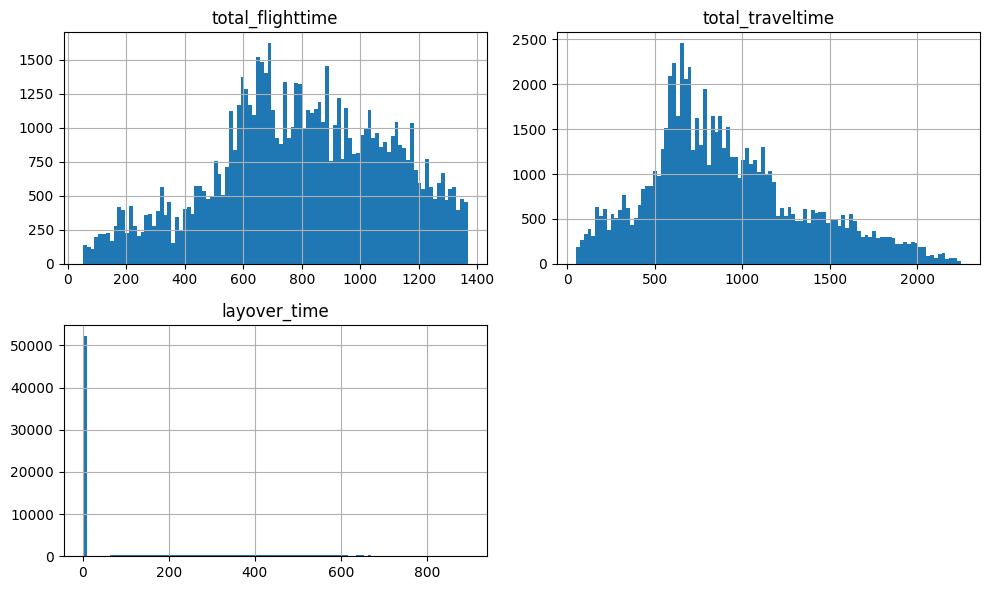

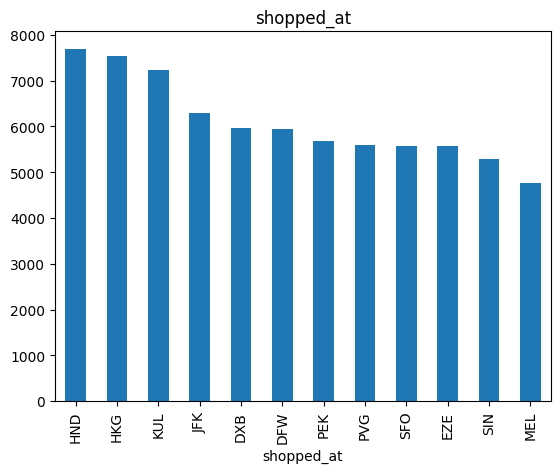

In [107]:
#   Inspect WW passengers table

print("--- WW passengers table (at proposed airports) ---")

display("Sample: ", passengers_ww_table.head())

display('Statistics: ', 
        passengers_ww_table.describe(include='all'))

print("Distributions: ")
passengers_ww_table.hist(bins=100, figsize=(10, 6), grid=True)
plt.tight_layout()
plt.show()

passengers_ww_table["shopped_at"].value_counts().plot(kind='bar', title="shopped_at")
plt.show()


### Problem definition and solution approach

Goal: Recommend the best airport location into which to invest

Solution approach: Train a classification model which allows to predict the correct category of amount of expenditure (0, 1, 2, 3, 4) for a given passenger

- Recommended airport = Airport with highest (sum of predicted expenditures over passengers)

In [108]:
#   Quick and dirty - Feature engineering

display(passengers_eu_table.head())


#   drop "birth_date" for now; encode later!!!!
X = passengers_eu_table.drop(columns=["amount_spent_cat", "name", "birth_date", "luggage", "flight_number_1", "flight_number_2"])


X = pd.get_dummies(data=X, columns=["sex", "shopped_at", "business_trip", "traveled_with_family", 
                                    "departure_IATA_1", "destination_IATA_1", "departure_IATA_2", "destination_IATA_2"])


y = passengers_eu_table["amount_spent_cat"]

display(X.head())
display(y.head())


,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Christian Kluge,m,1977/02/28,BCN,yes,no,Sports Bag 19l,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN
1,Bernd Jung,m,05/10/1971,MUC,no,no,Bag 19kg,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK
2,Ralph Dewhirst,m,10/04/1984,HEL,no,no,Duffel Bag [31KG],371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN
3,Jan Egger,m,1973/01/21,VIE,no,no,Bag 16kg,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN
4,Tom Probst,m,31/03/1985,FRA,yes,no,Bag (5KG),1197.70,1655.78,458.08,3,CA 6749,ZNZ,NaN,DL 7477,NaN,MEX


,total_flighttime,total_traveltime,layover_time,sex_f,sex_m,shopped_at_AMS,shopped_at_ARN,shopped_at_ATH,shopped_at_BCN,shopped_at_BRU,...,destination_IATA_2_WLG,destination_IATA_2_YHZ,destination_IATA_2_YOW,destination_IATA_2_YUL,destination_IATA_2_YVR,destination_IATA_2_YYC,destination_IATA_2_YYZ,destination_IATA_2_ZAG,destination_IATA_2_ZNZ,destination_IATA_2_ZRH
0,550.48,550.48,0.00,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1080.14,1142.62,62.48,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,371.48,371.48,0.00,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,148.88,148.88,0.00,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1197.70,1655.78,458.08,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


0    2
1    4
2    2
3    2
4    3
Name: amount_spent_cat, dtype: int64

In [109]:
#   Model training



# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Specify the learning task and the corresponding learning objective
    'num_class': 5,  # Number of classes in the dataset
    'max_depth': 9,  # Maximum depth of the tree
    'eta': 0.01,  # Learning rate
    'silent': 1  # Whether to print messages during training
}

# Convert the training and testing data into DMatrix format (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Train the XGBoost model
num_rounds = 100  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)



/Users/aleksej/opt/miniconda3/envs/airport-recommendation-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:58:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5625590804250009


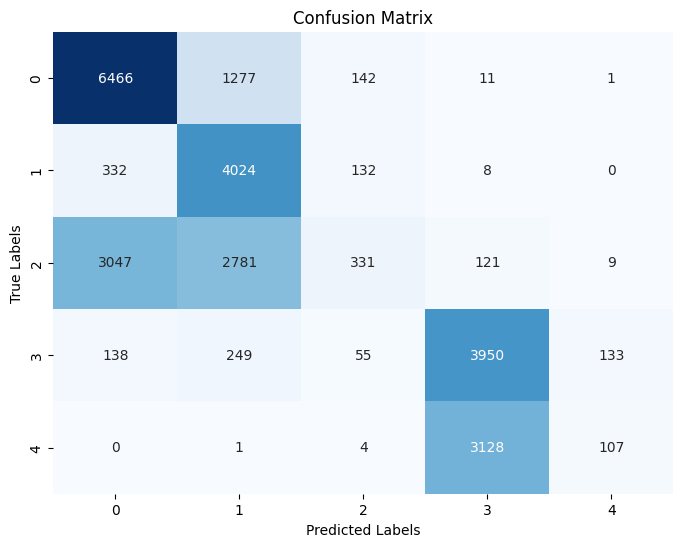

In [110]:
#   Evaluation


# Make predictions on the testing data
predictions = model.predict(dtest)


# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
